In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [14]:
# 1. Load dataset
df = pd.read_excel('Online Retail.xlsx')

# 2. Hapus data tanpa CustomerID dan pembatalan (Invoice diawali C)
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 3. Hitung TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [ ]:
# 4. Tanggal referensi
now = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# 5. Hitung RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

# 6. Normalisasi
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm)

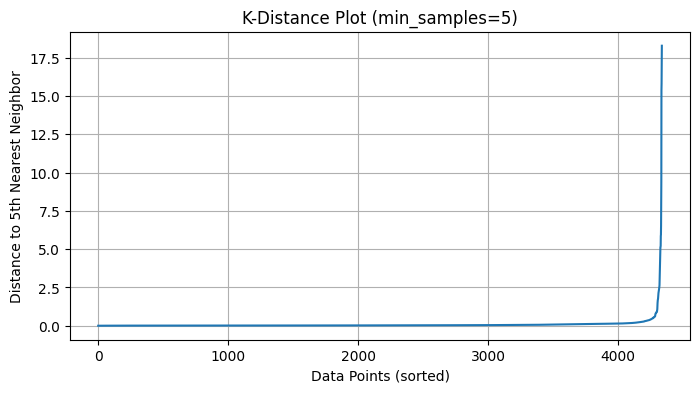

In [22]:
# --- K-DISTANCE PLOT untuk mencari eps optimal ---
min_samples = 5  # bisa dicoba juga 4, 6, dst
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Ambil jarak ke tetangga ke-5, lalu sort
distances = np.sort(distances[:, min_samples - 1])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title(f'K-Distance Plot (min_samples={min_samples})')
plt.xlabel('Data Points (sorted)')
plt.ylabel(f'Distance to {min_samples}th Nearest Neighbor')
plt.grid(True)
plt.show()

Distribusi Cluster (termasuk -1 sebagai outlier):
 {np.int64(-1): np.int64(22), np.int64(0): np.int64(4316)}

Cluster -1:
             Recency  Frequency   Monetary  Cluster
CustomerID                                        
12346.0         326          1   77183.60       -1
12415.0          24         21  124914.53       -1
12748.0           1        210   33719.73       -1
12971.0           4         86   11189.91       -1
13089.0           3         97   58825.83       -1

Cluster 0:
             Recency  Frequency  Monetary  Cluster
CustomerID                                       
12347.0           2          7   4310.00        0
12348.0          75          4   1797.24        0
12349.0          19          1   1757.55        0
12350.0         310          1    334.40        0
12352.0          36          8   2506.04        0


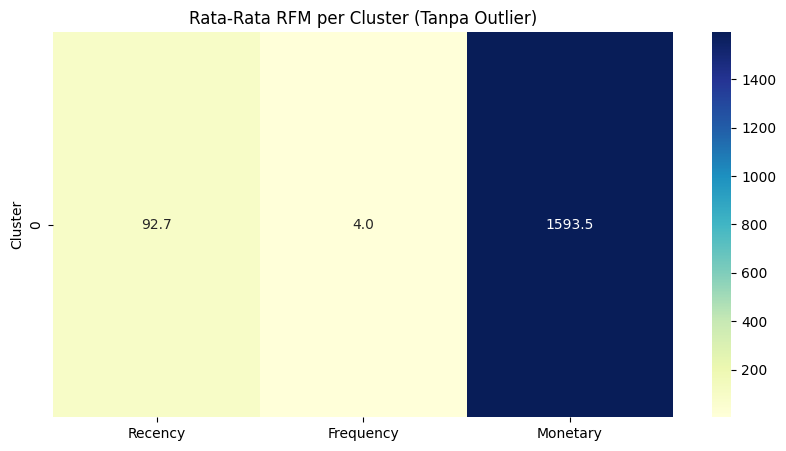

In [27]:
# --- DBSCAN ---
# Masukkan nilai eps berdasarkan hasil elbow dari plot
eps_value = 2  # ubah sesuai pengamatan dari grafik

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = dbscan.fit_predict(rfm_scaled)

# Tambahkan label cluster ke RFM
rfm['Cluster'] = labels

# Evaluasi jumlah cluster & outlier
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Distribusi Cluster (termasuk -1 sebagai outlier):\n", cluster_counts)

# Lihat contoh per cluster
for c in np.unique(labels):
    print(f"\nCluster {c}:\n", rfm[rfm['Cluster'] == c].head())

# Rata-rata per cluster (tanpa outlier)
rfm_clean = rfm[rfm['Cluster'] != -1]
cluster_avg = rfm_clean.groupby('Cluster').mean()

# Heatmap visualisasi
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_avg, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Rata-Rata RFM per Cluster (Tanpa Outlier)')
plt.show()

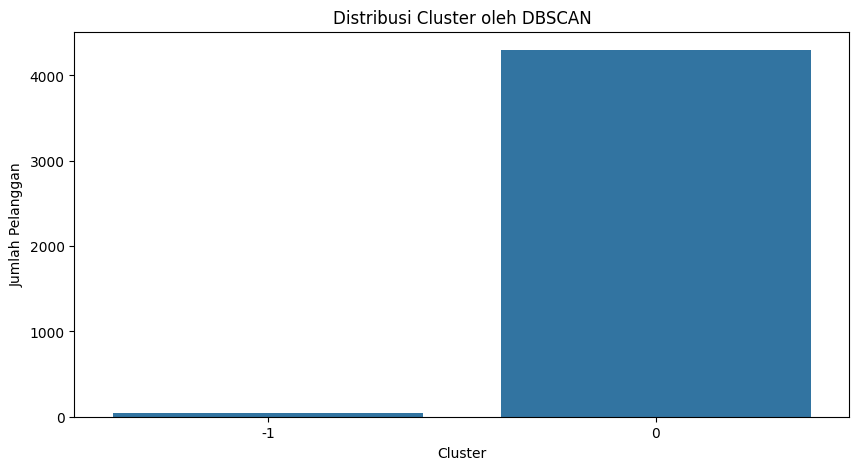

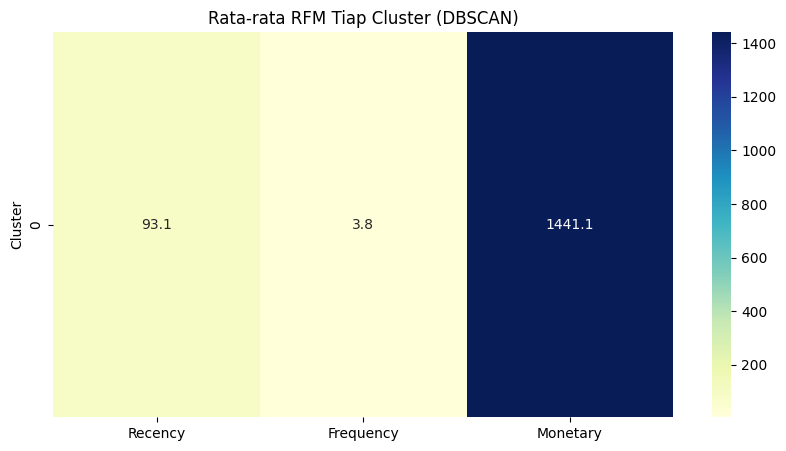

In [4]:
# 8. Visualisasi hasil
plt.figure(figsize=(10, 5))
sns.countplot(x='Cluster', data=rfm)
plt.title('Distribusi Cluster oleh DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# 9. Rata-rata RFM tiap cluster (abaikan cluster -1 = noise)
cluster_avg = rfm[rfm['Cluster'] != -1].groupby('Cluster').mean()
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_avg, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Rata-rata RFM Tiap Cluster (DBSCAN)')
plt.show()

In [5]:

# 10. Contoh output per cluster
for c in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {c}:\n", rfm[rfm['Cluster'] == c].head())


Cluster -1:
             Recency  Frequency   Monetary  Cluster
CustomerID                                        
12346.0         326          1   77183.60       -1
12415.0          24         21  124914.53       -1
12748.0           1        210   33719.73       -1
12753.0          23          6   21429.39       -1
12931.0          22         15   42055.96       -1

Cluster 0:
             Recency  Frequency  Monetary  Cluster
CustomerID                                       
12347.0           2          7   4310.00        0
12348.0          75          4   1797.24        0
12349.0          19          1   1757.55        0
12350.0         310          1    334.40        0
12352.0          36          8   2506.04        0
